In [ ]:
!pip install keras.utils
!pip install tensorflow

  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2656 sha256=490ca1ab0c65788d74c11693404f905ee8a07ed4c6b24b6748e3341b68fdefbc
  Stored in directory: /root/.cache/pip/wheels/d0/dd/3b/493952a5240d486a83805d65360dedadbadeae71d25e2c877f
Successfully built keras.utils


In [ ]:
import os
import numpy as np
import pandas as pd
import sklearn
import glob
import librosa
import time
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
import librosa.display

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder

In [ ]:
## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras import backend as K
import keras.utils
import json
from keras.models import model_from_json
import tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fear',
  '07':'disgust',
  '08':'surprised'
}

In [ ]:
labels = ['sad','angry','happy','disgust','neutral','fear']

In [ ]:
with zipfile.ZipFile("/content/drive/MyDrive/CS464 Project/Datasets/ryerson.zip","r") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive") 

In [ ]:
with zipfile.ZipFile("/content/drive/MyDrive/CS464 Project/Datasets/toronto.zip","r") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive") 

In [ ]:
def extract_feature(file_name, mfcc):
    X, sample_rate = librosa.load(os.path.join(file_name), res_type='kaiser_fast')
    if mfcc:
        mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((mfccs))
    return result

In [ ]:
X, sample_rate = librosa.load("/content/drive/MyDrive/ryerson/Actor_01/03-02-01-01-01-01-01.wav", res_type='kaiser_fast')
mfcc_l = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)

In [ ]:
S = librosa.feature.melspectrogram(X, sr=sample_rate, n_mels=40)
log_S = librosa.power_to_db(S, ref=np.max)

The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) that concisely describe the overall shape of a spectral envelope. It models the characteristics of the human voice.

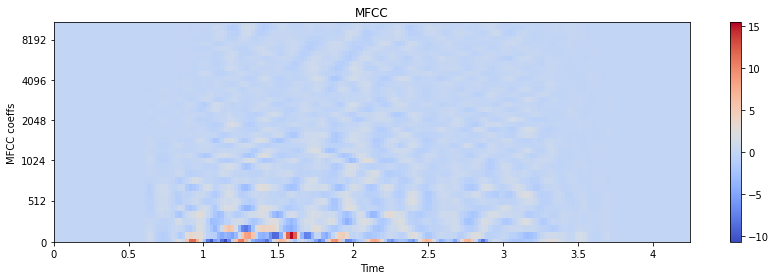

In [ ]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=40)

delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc, sr=sample_rate, x_axis='time', y_axis='mel')
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

# DATA PREPROCESSING

In [ ]:
def load_data(): 
    x,y=[],[]
    mfcc = True

    for file in os.listdir("/content/drive/MyDrive/ryerson"):
        path = "/content/drive/MyDrive/ryerson/"
        file_name = path+file
        for audio in os.listdir(file_name):
            audio_file = file_name + "/" + audio
            emotion=emotions[audio_file.split("-")[2]] 
            if emotion not in labels: 
                continue
            feature=extract_feature(audio_file, mfcc)
            x.append(feature)
            y.append(emotion)

    for file in os.listdir("/content/drive/MyDrive/toronto/TESS Toronto emotional speech set data"):
        path = "/content/drive/MyDrive/toronto/TESS Toronto emotional speech set data/"
        file_name = path+file
        for audio in os.listdir(file_name):
            audio_file = file_name + "/" + audio
            emotion=audio.split("_")[2][:-4] 
            if emotion not in labels: 
                continue
            feature=extract_feature(audio_file, mfcc)
            x.append(feature)
            y.append(emotion)

    return {"X":x,"y":y}

In [ ]:
Trial_dict = load_data()

In [ ]:
X = pd.DataFrame(Trial_dict["X"])
y = pd.DataFrame(Trial_dict["y"])

In [ ]:
#renaming the label column to emotion
y=y.rename(columns= {0: 'emotion'})

In [ ]:
data = pd.concat([X, y], axis =1)
data = data.reindex(np.random.permutation(data.index))
data.to_csv("MFCC.csv")

In [ ]:
data = pd.read_csv("MFCC.csv")

In [ ]:
data.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', 'emotion'],
      dtype='object')

In [ ]:
data = data.drop('Unnamed: 0',axis=1)

In [ ]:
X = data.drop('emotion', axis = 1).values
y = data['emotion'].values

In [ ]:
np.unique(y)

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'],
      dtype=object)

train val test split here
train (70%), validation (10%) and test (20%)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42) # 0.125 x 0.8 = 0.1

# CNN

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_val = np_utils.to_categorical(lb.fit_transform(y_val))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [ ]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_valcnn = np.expand_dims(X_val, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [ ]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0.0
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

In [ ]:
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(5)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(6))
model.add(Activation('softmax'))

# SGD OPTIMIZER

In [ ]:
opt = tensorflow.keras.optimizers.SGD(learning_rate=0.0001, decay=0.0)

# ADAM OPTIMIZER

In [ ]:
#opt = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

callback eklendi
epoch düştü

In [ ]:
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
# This callback will stop the training when there is no improvement in
# the loss for twenty consecutive epochs.

In [ ]:
mcp_save = ModelCheckpoint('model/cnnmodel.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_valcnn, y_val), callbacks=[callback, mcp_save])

Epoch 1/700
142/142 [==============================] - 5s 23ms/step - loss: 1.8466 - accuracy: 0.1324 - fscore: 0.0000e+00 - val_loss: 1.8046 - val_accuracy: 0.1022 - val_fscore: 0.0000e+00
Epoch 2/700
142/142 [==============================] - 3s 20ms/step - loss: 1.8334 - accuracy: 0.1346 - fscore: 0.0000e+00 - val_loss: 1.8059 - val_accuracy: 0.1889 - val_fscore: 0.0000e+00
Epoch 3/700
142/142 [==============================] - 3s 20ms/step - loss: 1.8234 - accuracy: 0.1580 - fscore: 0.0000e+00 - val_loss: 1.8043 - val_accuracy: 0.1146 - val_fscore: 0.0000e+00
Epoch 4/700
142/142 [==============================] - 3s 19ms/step - loss: 1.8150 - accuracy: 0.1700 - fscore: 0.0000e+00 - val_loss: 1.7994 - val_accuracy: 0.1610 - val_fscore: 0.0000e+00
Epoch 5/700
142/142 [==============================] - 3s 20ms/step - loss: 1.8094 - accuracy: 0.1788 - fscore: 0.0000e+00 - val_loss: 1.7933 - val_accuracy: 0.1641 - val_fscore: 0.0000e+00
Epoch 6/700
142/142 [=============================

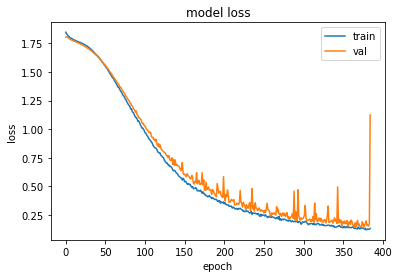

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [ ]:
# Saving the model.json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# loading json and creating model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model/cnnmodel.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 95.20%


In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
predicted = loaded_model.predict(x_testcnn)

In [ ]:
y_pred = np.zeros_like(predicted)
y_pred[np.arange(len(predicted)), predicted.argmax(1)] = 1

In [ ]:
c = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

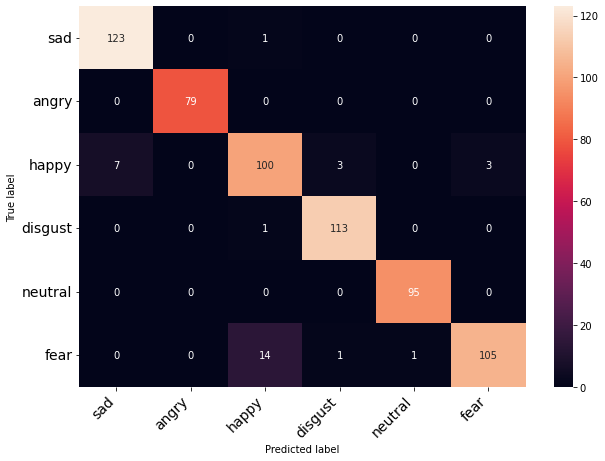

In [ ]:
print_confusion_matrix(c, labels)

In [ ]:
print(precision(predicted, y_test))
print(recall(predicted, y_test))
print(fscore(predicted, y_test))

tf.Tensor(0.9303405, shape=(), dtype=float32)
tf.Tensor(0.9724919, shape=(), dtype=float32)
tf.Tensor(0.95094925, shape=(), dtype=float32)
